## Train a sparse semantic unet on patches from vessels gray scale image 

In this notebook we use the patches created in notebook ```21_Make_patches``` (which are generated from the labels in ```15_sparse_label```) as training data for a semantic segmentation unet. 

Imports:  Note on Linux for some reason we have to import and show Napari before importing PyTorch. 

In [ ]:
import napari
viewer = napari.Viewer()

import numpy as np
import torch

from tnia.deeplearning.dl_helper import collect_training_data, divide_training_data
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
from semantic_dataset import SemanticDataset
import random
from torch.utils.tensorboard import SummaryWriter
import datetime
from torch.utils.data import DataLoader
from semantic_helper import train
from monai.networks.nets import BasicUNet
from pathlib import Path
import os

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check if Cuda is present

If cuda is not present training will be slow... 

In [2]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


## Set Parent Path

This is the path that contains the images we will work with and pre-existing patches that would have been created in notebook ```33_label_semantic_sparse_rgb```

In [3]:

#tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
tnia_images_path = Path(r"D:\images\tnia-python-images")
parent_path = tnia_images_path / "imagesc/2025_03_19_vessel_3D_lightsheet"

train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Collect training data

Collect the training data that would have been created in ```33_label_semantic_sparse_rgb.ipynb```

In [4]:
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel=False, relabel=False)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

100%|██████████| 1000/1000 [00:02<00:00, 455.37it/s]

Number of input images 1000
Number of ground truth images  1000
Size of first input image (512, 512)
Size of first ground truth image  (512, 512)


In [5]:
X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, 2, to_numpy=False)

print('Number of training images', len(X_train))
print('Number of validaiton images ', len(X_val))

Number of training images 998
Number of validaiton images  2


In [6]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

X_test = X_val
Y_test = Y_val

X_train.shape, Y_train.shape

((998, 512, 512), (998, 512, 512))

In [7]:
Y_train = Y_train.astype(np.int16)-1
Y_test = Y_test.astype(np.int16)-1
Y_val = Y_val.astype(np.int16)-1

Y_train[Y_train==3] = 2
Y_test[Y_test==3] = 2
Y_val[Y_val==3] = 2

In [8]:
print(Y_train.min(), Y_train.max())
print(Y_test.min(), Y_test.max())
print(Y_val.min(), Y_val.max())

-1 2
-1 2
-1 2


## Preview Training Data

Just make sure it looks right and labels correspond to objects properly

int16
(512, 512) (512, 512)
0.1968213 1.0
float32 (512, 512) 0.1968213 1.0


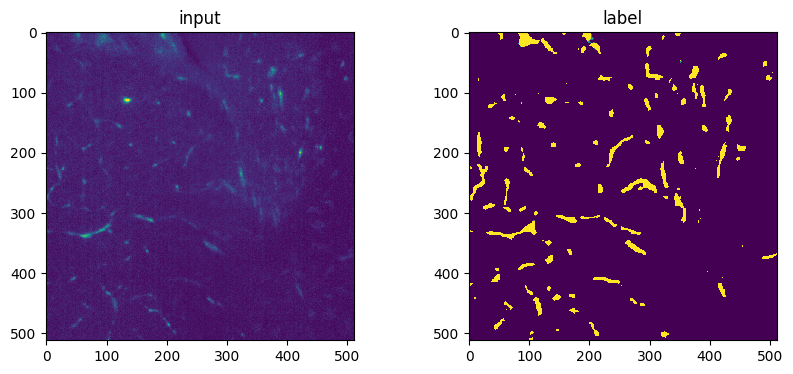

In [9]:
n=25
X_ = X_train[n]
Y_ = Y_train[n]
print(Y_.dtype)

print(X_.shape, Y_.shape)
print(X_.min(), X_.max())
print(X_.dtype, X_.shape, X_.min(), X_.max())
fig=imshow_multi2d([X_, Y_], ['input', 'label'], 1,2)

## Create Datasets

In [10]:
train_dataset = SemanticDataset(X_train, Y_train, crop_size=256)
test_dataset = SemanticDataset(X_val, Y_val, crop_size=256)
val_dataset = SemanticDataset(X_val, Y_val, crop_size=256)

# verify that the dataset is working
raw, mask = train_dataset[random.randrange(len(train_dataset))]
raw = np.transpose(raw, (1,2,0))
raw.shape,mask.shape

((512, 512, 1), (1, 512, 512))

## Visualize a few datasets

-1 2
-1 2
0 2


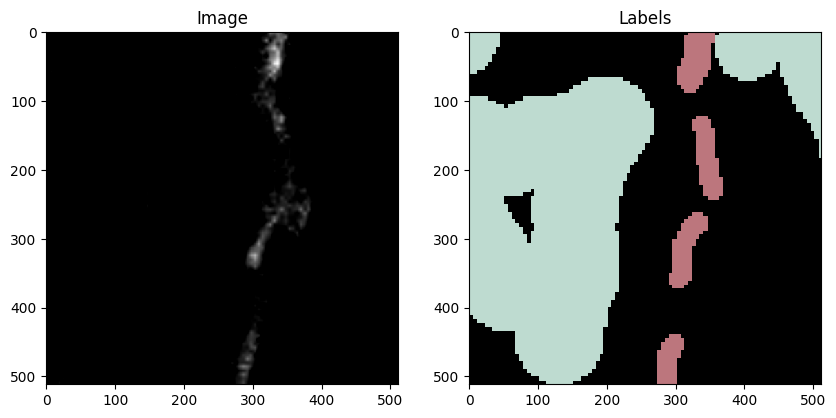

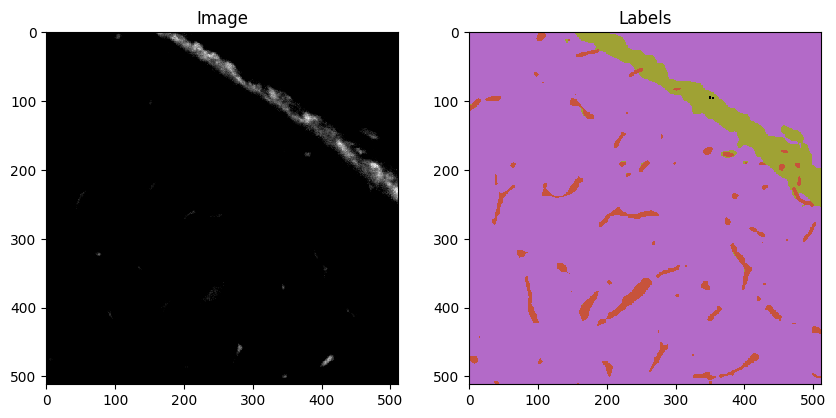

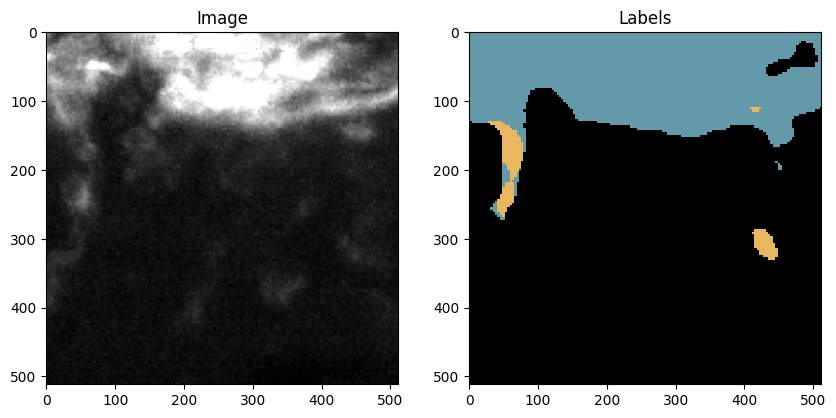

In [11]:
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

raw, mask = train_dataset[10]
fig = imshow_multi2d([np.transpose(raw, (1,2,0)), mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
print(mask.min(), mask.max())

## Set up unet

We use monai BasicUnet.

Since image is RGB in_channels are 3

Since the dataset we are working with has 3 classes, out_channels are 3

No activation function since we are using CrossEntropyLoss which applies softmax
Note: predictor will need to use a softmax activation function



In [13]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
dtype = torch.LongTensor

net = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=3,
    #features=[16, 16, 32, 64, 128, 16],
    act=None,
    #norm="batch",
    #norm=None,
    #dropout=0.25,
)

net = torch.load( Path(model_path) / 'model_march22.pth')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
loss_fn = loss_fn.to(device)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

BasicUNet features: (32, 32, 64, 128, 256, 32).


## Start training process

In [14]:
train_batch_size =32 
test_batch_size = 1

learning_rate = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

training_steps = 500

train(train_loader, val_loader, net, loss_fn, optimizer, dtype, 30, device)
#test_data_loader(train_loader, val_loader, net2, loss_fn, optimizer, dtype, 1, 100, device, writer)
#train(train_loader, val_loader, net2, loss_fn, None, optimizer, dtype, 10, device, writer)


torch.save(net, Path(model_path) / 'model_march25.pth')

Epoch 0: 100%|██████████| 998/998 [02:27<00:00,  6.75it/s]


training loss at epoch 0 is 0.006025987421582362


Epoch 1: 100%|██████████| 998/998 [02:26<00:00,  6.80it/s]


training loss at epoch 1 is 0.005330482098406445


Epoch 2: 100%|██████████| 998/998 [02:26<00:00,  6.80it/s]


training loss at epoch 2 is 0.005036572237052994


Epoch 3: 100%|██████████| 998/998 [02:26<00:00,  6.79it/s]


training loss at epoch 3 is 0.005137912316886122


Epoch 4: 100%|██████████| 998/998 [02:26<00:00,  6.80it/s]


training loss at epoch 4 is 0.004766734776074041


Epoch 5: 100%|██████████| 998/998 [02:26<00:00,  6.82it/s]


training loss at epoch 5 is 0.00469649488289275


Epoch 6: 100%|██████████| 998/998 [02:25<00:00,  6.84it/s]


training loss at epoch 6 is 0.004576643507084054


Epoch 7: 100%|██████████| 998/998 [02:25<00:00,  6.87it/s]


training loss at epoch 7 is 0.004486315960217573


Epoch 8: 100%|██████████| 998/998 [02:25<00:00,  6.85it/s]


training loss at epoch 8 is 0.004433953705316555


Epoch 9: 100%|██████████| 998/998 [02:26<00:00,  6.81it/s]


training loss at epoch 9 is 0.004347217913142187


Epoch 10: 100%|██████████| 998/998 [02:26<00:00,  6.80it/s]


training loss at epoch 10 is 0.004321788947185677


Epoch 11: 100%|██████████| 998/998 [02:26<00:00,  6.81it/s]


training loss at epoch 11 is 0.004310690568300909


Epoch 12: 100%|██████████| 998/998 [02:26<00:00,  6.80it/s]


training loss at epoch 12 is 0.004128451188484987


Epoch 13: 100%|██████████| 998/998 [02:26<00:00,  6.81it/s]


training loss at epoch 13 is 0.004283474567896856


Epoch 14: 100%|██████████| 998/998 [02:26<00:00,  6.82it/s]


training loss at epoch 14 is 0.0046378043750842255


Epoch 15: 100%|██████████| 998/998 [02:26<00:00,  6.79it/s]


training loss at epoch 15 is 0.0041556164756686035


Epoch 16: 100%|██████████| 998/998 [02:26<00:00,  6.81it/s]


training loss at epoch 16 is 0.0040815762339350215


Epoch 17: 100%|██████████| 998/998 [02:26<00:00,  6.79it/s]


training loss at epoch 17 is 0.004272313493645502


Epoch 18: 100%|██████████| 998/998 [02:26<00:00,  6.79it/s]


training loss at epoch 18 is 0.004127374213778662


Epoch 19: 100%|██████████| 998/998 [02:26<00:00,  6.80it/s]


training loss at epoch 19 is 0.003997502598411334


Epoch 20: 100%|██████████| 998/998 [02:26<00:00,  6.82it/s]


training loss at epoch 20 is 0.003961347289876135


Epoch 21: 100%|██████████| 998/998 [02:25<00:00,  6.86it/s]


training loss at epoch 21 is 0.003942957286067859


Epoch 22: 100%|██████████| 998/998 [02:25<00:00,  6.85it/s]


training loss at epoch 22 is 0.004401743665845217


Epoch 23: 100%|██████████| 998/998 [02:26<00:00,  6.83it/s]


training loss at epoch 23 is 0.004528664769175535


Epoch 24: 100%|██████████| 998/998 [02:25<00:00,  6.85it/s]


training loss at epoch 24 is 0.003915091427808296


Epoch 25: 100%|██████████| 998/998 [02:25<00:00,  6.85it/s]


training loss at epoch 25 is 0.003824771115022575


Epoch 26: 100%|██████████| 998/998 [02:26<00:00,  6.83it/s]


training loss at epoch 26 is 0.0038331810586557597


Epoch 27: 100%|██████████| 998/998 [02:26<00:00,  6.82it/s]


training loss at epoch 27 is 0.003808030571213705


Epoch 28: 100%|██████████| 998/998 [02:26<00:00,  6.81it/s]


training loss at epoch 28 is 0.003953895372952631


Epoch 29: 100%|██████████| 998/998 [02:25<00:00,  6.84it/s]

training loss at epoch 29 is 0.0038192329894684122


## Test predictions

In [ ]:

import torch.nn.functional as F

rlcm = random_label_cmap()

for i in range(20):
    #features, label = train_loader.dataset[random.randrange(len(train_loader.dataset))]
    features, label = train_loader.dataset[i]
    
    net.eval()
    features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)       
    #features = features.todevice()
    predicted = net(features_tensor)

    print(predicted.shape, features.shape)

    features = np.transpose(features, (1,2,0))

    predicted.shape
    c1 = predicted[0,0,:,:].cpu().detach().numpy()
    c2 = predicted[0,1,:,:].cpu().detach().numpy()

    # Apply softmax along the class dimension (dim=1)
    probabilities = F.softmax(predicted, dim=1)
    predicted_classes = torch.argmax(probabilities, dim=1)
    
    fig = imshow_multi2d([features, label, c1, c2, predicted_classes], ['Image', 'label', 'Class 1', 'Class 2', 'predicted'], 1, 5, 12, 12,colormaps=['gray', rlcm, 'viridis', 'viridis', rlcm])

NameError: name 'train_loader' is not defined